# 11 - Coreset Ratio Analysis for PatchCore

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/code_refactor/notebooks/11_coreset_ratio_analysis_on_shift.ipynb)

**Objective**: This notebook analyzes the impact of **coreset ratio** on PatchCore's performance during full shift adaptation.

We train PatchCore models with **three different coreset ratios**:
- **1% coreset** → Files: `*_coreset_01.*`
- **5% coreset** → Files: `*_shift_full_adaptation.*` (from notebook 09)
- **10% coreset** → Files: `*_coreset_10.*`

**Structure**:
1. **PART A**: Train and evaluate PatchCore with **1% coreset**
2. **PART B**: Train and evaluate PatchCore with **10% coreset**  
3. **PART C**: Compare all three ratios (1%, 5%, 10%)

**Key Metrics**:
- **Performance**: AUROC, AUPRC, F1-Score
- **Efficiency**: Training time, Memory bank size
- **Trade-off**: Performance vs computational cost

**File naming convention**:
- 1% models: `patchcore_{class}_shift_coreset_01.*`
- 5% models: `patchcore_{class}_shift.*` (already generated in notebook 09)
- 10% models: `patchcore_{class}_shift_coreset_10.*`



## 1. Setup - Mount Drive & Clone Repository

In [11]:
from google.colab import drive
from pathlib import Path
import os
import sys

drive.mount('/content/drive')

repo_dir = '/content/Detection-of-Anomalies-with-Localization'

# Remove if exists
if os.path.exists(repo_dir):
    print("Removing existing repository...")
    !rm -rf {repo_dir}

# Clone from main branch
!git clone -b code_refactor https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git {repo_dir}

# Setup paths
PROJECT_ROOT = Path(repo_dir)

# Dataset locations (both clean and shifted)
CLEAN_DATASET_PATH = Path('/content/drive/MyDrive/mvtec_ad')
SHIFTED_DATASET_PATH = Path('/content/drive/MyDrive/mvtec_shifted')

# Output directories
MODELS_DIR = PROJECT_ROOT / 'outputs' / 'models'
RESULTS_DIR = PROJECT_ROOT / 'outputs' / 'results'
THRESHOLDS_DIR = PROJECT_ROOT / 'outputs' / 'thresholds'
VIZ_DIR = PROJECT_ROOT / 'outputs' / 'visualizations' / 'shifted_coreset_ratio_analysis'

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
THRESHOLDS_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Verify datasets exist
if not CLEAN_DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Clean dataset not found at {CLEAN_DATASET_PATH}\n"
        f"Please ensure mvtec_ad folder is in your Google Drive."
    )

if not SHIFTED_DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Shifted dataset not found at {SHIFTED_DATASET_PATH}\n"
        f"Please run notebook 03_domain_shift_generation.ipynb first."
    )

# Add project root to Python path
sys.path.insert(0, str(PROJECT_ROOT))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Removing existing repository...
Cloning into '/content/Detection-of-Anomalies-with-Localization'...
remote: Enumerating objects: 1532, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 1532 (delta 16), reused 34 (delta 11), pack-reused 1460 (from 1)
Receiving objects: 100% (1532/1532), 434.20 MiB | 21.63 MiB/s, done.
Resolving deltas: 100% (848/848), done.
Updating files: 100% (175/175), done.
Error downloading object: outputs/models/padim_carpet_clean.pt (c5f08e6): Smudge error: Error downloading outputs/models/padim_carpet_clean.pt (c5f08e6a66aaad9c354e37e3dfcdc363d0fc17764922d97746ee0ff947df2768): batch response: This repository exceeded its LFS budget. The account responsible for the budget should increase it to restore access.

Errors logged to /content/Detection-of-Anomalies-with-Localizat

## 2. Install Dependencies

In [12]:
!pip install faiss-cpu --quiet
!pip install anomalib --quiet

## 3. Import Libraries

In [13]:

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import warnings
from tqdm import tqdm
from datetime import datetime

# Project imports
from src.utils.reproducibility import set_seed
from src.utils.config import load_config
from src.utils.paths import ProjectPaths
from src.data.splitter import load_splits
from src.data.dataset import MVTecDataset
from src.data.transforms import get_clean_transforms
from src.models.patchcore import PatchCore
from src.models.padim_wrapper import PadimWrapper
from src.utils.utils import custom_collate_fn

# Metrics imports
from src.metrics import (
    calibrate_threshold,
    calibrate_threshold_with_curve,
    ThresholdCalibrator,
    compute_image_metrics,
    compute_pixel_metrics,
    compute_roc_curve,
    compute_pr_curve,
    compute_confusion_matrix,
    aggregate_metrics,
    aggregate_pixel_metrics
)

# Set random seed for reproducibility
set_seed(42)

# Load configuration
config = load_config(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
paths = ProjectPaths(PROJECT_ROOT)

# Classes to process
CLASSES = config.dataset.classes  # ['hazelnut', 'carpet', 'zipper']

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}")

Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
Using device: cpu


## 4. Load Shifted Splits

In [14]:
# Load shifted splits
SHIFTED_SPLITS_PATH = paths.get_split_path('shifted')
shifted_splits = load_splits(SHIFTED_SPLITS_PATH)

# Print split statistics
print("\nShifted Split Statistics:")
print("-" * 70)
for class_name in CLASSES:
    train_n = len(shifted_splits[class_name]['train']['images'])
    val_n = len(shifted_splits[class_name]['val']['images'])
    test_n = len(shifted_splits[class_name]['test']['images'])

    val_normal = sum(1 for l in shifted_splits[class_name]['val']['labels'] if l == 0)
    val_anom = sum(1 for l in shifted_splits[class_name]['val']['labels'] if l == 1)
    test_normal = sum(1 for l in shifted_splits[class_name]['test']['labels'] if l == 0)
    test_anom = sum(1 for l in shifted_splits[class_name]['test']['labels'] if l == 1)

    print(f"{class_name}:")
    print(f"  Train-shift: {train_n} (all normal)")
    print(f"  Val-shift: {val_n} ({val_normal} normal, {val_anom} anomalous)")
    print(f"  Test-shift: {test_n} ({test_normal} normal, {test_anom} anomalous)")
print("-" * 70)


Shifted Split Statistics:
----------------------------------------------------------------------
hazelnut:
  Train-shift: 312 (all normal)
  Val-shift: 100 (79 normal, 21 anomalous)
  Test-shift: 89 (40 normal, 49 anomalous)
carpet:
  Train-shift: 224 (all normal)
  Val-shift: 82 (56 normal, 26 anomalous)
  Test-shift: 91 (28 normal, 63 anomalous)
zipper:
  Train-shift: 192 (all normal)
  Val-shift: 83 (48 normal, 35 anomalous)
  Test-shift: 116 (32 normal, 84 anomalous)
----------------------------------------------------------------------


## 5. Prepare Data Transforms and Loaders

In [15]:
# Create transform for shifted data (same as clean - no additional augmentation)
# The domain shift is already "baked" into the shifted dataset images
transform = get_clean_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std
)

---
# PART A: PATCHCORE - 1% CORESET
---

## 6. Re-train PatchCore on Train-Shift (1% Coreset)

In [16]:
# Hyperparameters
CORESET_RATIO = 0.01
BATCH_SIZE = 8
NUM_WORKERS = 0  # Set to 0 for Colab

print("\n" + "="*70)
print("PATCHCORE - TRAINING ON TRAIN-SHIFT (1% CORESET)")
print("="*70)
print(f"Coreset ratio: {CORESET_RATIO*100:.1f}%")
print(f"Batch size: {BATCH_SIZE}")
print(f"Num workers: {NUM_WORKERS}")
print(f"Image size: {config.dataset.image_size}")
print(f"Backbone layers: {config.patchcore.layers}")
print(f"Patch size: {config.patchcore.patch_size}")
print(f"N neighbors: {config.patchcore.n_neighbors}")
print("="*70)


PATCHCORE - TRAINING ON TRAIN-SHIFT (1% CORESET)
Coreset ratio: 1.0%
Batch size: 8
Num workers: 0
Image size: 224
Backbone layers: ['layer2', 'layer3']
Patch size: 3
N neighbors: 9


In [17]:

# Train PatchCore models on shifted data
patchcore_models_shift = {}
patchcore_training_stats_shift = {}

for class_name in CLASSES:
    print("\n" + "=" * 70)
    print(f"Training PatchCore on TRAIN-SHIFT: {class_name.upper()}")
    print("=" * 70)

    # Check if model files already exist
    model_file = paths.MODELS / f'patchcore_{class_name}_shift_coreset_01.npy'
    config_file = paths.MODELS / f'patchcore_{class_name}_shift_coreset_01_config.pth'

    if model_file.exists() and config_file.exists():
        print(f"\nModel files found! Loading existing model...")
        print(f"  • {model_file.name}")
        print(f"  • {config_file.name}")

        # Load existing model
        model = PatchCore(
            backbone_layers=config.patchcore.layers,
            patch_size=config.patchcore.patch_size,
            coreset_ratio=CORESET_RATIO,
            n_neighbors=config.patchcore.n_neighbors,
            device=DEVICE
        )
        model.load(paths.MODELS, class_name, domain='shift')

        # Load training stats from config file
        checkpoint = torch.load(config_file, map_location=DEVICE)
        patchcore_training_stats_shift[class_name] = {
            'n_train_images': checkpoint.get('n_train_images', 'N/A'),
            'memory_bank_size': len(model.memory_bank),
            'training_time_seconds': checkpoint.get('training_time_seconds', 'N/A'),
            'spatial_dims': model.spatial_dims
        }

        print(f"  Memory bank size: {len(model.memory_bank)}")
        print(f"  Spatial dims: {model.spatial_dims}")
        print("  [SKIPPED TRAINING - Using cached model]")

    else:
        print(f"\n Model files not found. Starting training from scratch...")

        # Create train dataset (only normal images from shifted data)
        train_split = shifted_splits[class_name]['train']
        train_dataset = MVTecDataset.from_split(
            train_split,
            transform=transform,
            phase='train'
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
            collate_fn=custom_collate_fn
        )

        print(f"\nTrain-shift dataset: {len(train_dataset)} images")

        # Initialize PatchCore
        model = PatchCore(
            backbone_layers=config.patchcore.layers,
            patch_size=config.patchcore.patch_size,
            coreset_ratio=CORESET_RATIO,
            n_neighbors=config.patchcore.n_neighbors,
            device=DEVICE
        )

        # Fit model
        start_time = time.time()
        model.fit(train_loader, apply_coreset=True)
        training_time = time.time() - start_time

        # Save model with 'shift_coreset_01' domain tag
        model.save(paths.MODELS, class_name, domain='shift_coreset_01')

        # Store statistics
        patchcore_training_stats_shift[class_name] = {
            'n_train_images': len(train_dataset),
            'memory_bank_size': len(model.memory_bank),
            'training_time_seconds': training_time,
            'spatial_dims': model.spatial_dims
        }

        print(f"\nCompleted {class_name.upper()}:")
        print(f"  Memory bank size: {len(model.memory_bank)}")
        print(f"  Training time: {training_time:.2f}s")
        print(f"  Spatial dims: {model.spatial_dims}")

    # Store model in dictionary
    patchcore_models_shift[class_name] = model


Training PatchCore on TRAIN-SHIFT: HAZELNUT

 Model files not found. Starting training from scratch...

Train-shift dataset: 312 images


Extracting features: 100%|██████████| 39/39 [01:34<00:00,  2.42s/it]



Completed HAZELNUT:
  Memory bank size: 2446
  Training time: 563.30s
  Spatial dims: (28, 28)

Training PatchCore on TRAIN-SHIFT: CARPET

 Model files not found. Starting training from scratch...

Train-shift dataset: 224 images


Extracting features: 100%|██████████| 28/28 [01:02<00:00,  2.22s/it]



Completed CARPET:
  Memory bank size: 1756
  Training time: 310.18s
  Spatial dims: (28, 28)

Training PatchCore on TRAIN-SHIFT: ZIPPER

 Model files not found. Starting training from scratch...

Train-shift dataset: 192 images


Extracting features: 100%|██████████| 24/24 [00:50<00:00,  2.10s/it]
                                                                     


Completed ZIPPER:
  Memory bank size: 1505
  Training time: 229.10s
  Spatial dims: (28, 28)


## 7. PatchCore 1% - Predict on Val-Shift for Threshold Calibration

In [18]:
patchcore_val_predictions_shift = {}

for class_name in CLASSES:
    print(f"\nProcessing {class_name.upper()}...")

    model = patchcore_models_shift[class_name]

    # Load val-shift data
    val_split = shifted_splits[class_name]['val']
    val_dataset = MVTecDataset.from_split(
        val_split,
        transform=transform,
        phase='val'
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Predict
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(val_loader, desc=f"Val-shift {class_name}"):
            images = images.to(DEVICE)
            scores, _ = model.predict(images, return_heatmaps=True)
            all_scores.extend(scores)
            all_labels.extend(labels.numpy())

    patchcore_val_predictions_shift[class_name] = {
        'scores': all_scores,
        'labels': all_labels
    }

    print(f"  Val-shift predictions: {len(all_scores)} samples")
    print(f"  Normal: {sum(1 for l in all_labels if l == 0)}, Anomalous: {sum(1 for l in all_labels if l == 1)}")


Processing HAZELNUT...


Val-shift hazelnut: 100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


  Val-shift predictions: 100 samples
  Normal: 79, Anomalous: 21

Processing CARPET...


Val-shift carpet: 100%|██████████| 11/11 [00:28<00:00,  2.63s/it]


  Val-shift predictions: 82 samples
  Normal: 56, Anomalous: 26

Processing ZIPPER...


Val-shift zipper: 100%|██████████| 11/11 [00:28<00:00,  2.59s/it]

  Val-shift predictions: 83 samples
  Normal: 48, Anomalous: 35


## 8. PatchCore 1% - Calibrate Thresholds on Val-Shift

In [19]:
patchcore_thresholds_path = THRESHOLDS_DIR / 'patchcore_shift_coreset_01_thresholds.json'

# Check if thresholds already exist
if patchcore_thresholds_path.exists():
    print(f"\n Threshold file found! Loading existing thresholds...")
    print(f"  • {patchcore_thresholds_path.name}")

    # Load raw JSON to inspect
    with open(patchcore_thresholds_path, 'r') as f:
        threshold_data = json.load(f)

    # Check if thresholds dict exists and has data
    if 'thresholds' in threshold_data and len(threshold_data['thresholds']) > 0:
        patchcore_calibrator_shift = ThresholdCalibrator('patchcore_shift')

        # Map class names (case-insensitive)
        saved_thresholds = threshold_data['thresholds']

        # Try to match class names
        for class_name in CLASSES:
            # Try exact match first
            if class_name in saved_thresholds:
                patchcore_calibrator_shift.thresholds[class_name] = saved_thresholds[class_name]
            # Try case-insensitive match
            elif class_name.lower() in [k.lower() for k in saved_thresholds.keys()]:
                matching_key = [k for k in saved_thresholds.keys() if k.lower() == class_name.lower()][0]
                patchcore_calibrator_shift.thresholds[class_name] = saved_thresholds[matching_key]
                print(f"Remapped '{matching_key}' → '{class_name}'")
            else:
                print(f"Missing threshold for '{class_name}', will recalibrate")
                # Recalibrate this class
                scores = np.array(patchcore_val_predictions_shift[class_name]['scores'])
                labels = np.array(patchcore_val_predictions_shift[class_name]['labels'])
                threshold = patchcore_calibrator_shift.calibrate(class_name, scores, labels)
                print(f"New threshold: {threshold:.4f}")

        print("\nLoaded thresholds:")
        for class_name in CLASSES:
            threshold = patchcore_calibrator_shift.get_threshold(class_name)
            print(f"  {class_name}: {threshold:.4f}")

        # Re-save with correct keys
        patchcore_calibrator_shift.save(patchcore_thresholds_path)
        print(f"  [Thresholds normalized and saved]")
    else:
        print(f"\nThreshold file is empty or invalid, recalibrating...")
        raise ValueError("Empty thresholds, skip to else block")

else:
    print(f"\nThreshold file not found. Starting calibration from scratch...")

    patchcore_calibrator_shift = ThresholdCalibrator('patchcore_shift')

    for class_name in CLASSES:
        print(f"\n{class_name.upper()}:")

        scores = np.array(patchcore_val_predictions_shift[class_name]['scores'])
        labels = np.array(patchcore_val_predictions_shift[class_name]['labels'])

        threshold = patchcore_calibrator_shift.calibrate(class_name, scores, labels)

        print(f"  Optimal threshold: {threshold:.4f}")
        print(f"  Score range: [{scores.min():.4f}, {scores.max():.4f}]")

    # Save thresholds
    patchcore_calibrator_shift.save(patchcore_thresholds_path)
    print(f"\nPatchCore 1% thresholds saved to: {patchcore_thresholds_path}")


Threshold file not found. Starting calibration from scratch...

HAZELNUT:
  Optimal threshold: 480.6034
  Score range: [328.3240, 1283.1169]

CARPET:
  Optimal threshold: 240.3369
  Score range: [161.0498, 936.0012]

ZIPPER:
  Optimal threshold: 252.3692
  Score range: [197.5007, 739.1910]
[OK] Thresholds saved: patchcore_shift_coreset_01_thresholds.json

PatchCore 1% thresholds saved to: /content/Detection-of-Anomalies-with-Localization/outputs/thresholds/patchcore_shift_coreset_01_thresholds.json


## 9. PatchCore 1% - Evaluate on Test-Shift

In [20]:
patchcore_results_shift = {}

for class_name in CLASSES:
    print(f"\n{'='*70}")
    print(f"Evaluating {class_name.upper()}")
    print(f"{'='*70}")

    model = patchcore_models_shift[class_name]
    threshold = patchcore_calibrator_shift.get_threshold(class_name)

    # Load test-shift data
    test_split = shifted_splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Predict
    all_scores = []
    all_heatmaps = []
    all_labels = []
    all_masks = []
    all_paths = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f"Test-shift {class_name}"):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            all_scores.extend(scores.tolist())
            all_heatmaps.extend(heatmaps.tolist())
            all_labels.extend(labels.numpy())
            all_masks.extend(masks)
            all_paths.extend(paths)

    all_scores = np.array(all_scores)
    all_heatmaps = np.array(all_heatmaps)
    all_labels = np.array(all_labels)

    # Image-level metrics
    image_metrics = compute_image_metrics(
        all_labels,
        all_scores,
        threshold=threshold
    )

    # Pixel-level metrics (only for anomalous images with masks)
    pixel_metrics = None
    anomalous_indices = [i for i, l in enumerate(all_labels) if l == 1]
    if len(anomalous_indices) > 0:
        masks_true = []
        heatmaps_pred = []

        for i in anomalous_indices:
            mask = all_masks[i]
            if mask is not None:
                if isinstance(mask, torch.Tensor):
                    mask_np = mask.cpu().numpy().squeeze()  # (1, H, W) → (H, W)
                else:
                    mask_np = np.array(mask).squeeze()

                masks_true.append(mask_np)
                heatmaps_pred.append(all_heatmaps[i])

        if len(masks_true) > 0:
            pixel_metrics = compute_pixel_metrics(masks_true, heatmaps_pred)

    patchcore_results_shift[class_name] = {
        'image_metrics': image_metrics,
        'pixel_metrics': pixel_metrics,
        'threshold': threshold,
        'n_test_samples': len(all_labels),
        'n_anomalous': sum(all_labels),
        'predictions': {
            'scores': all_scores.tolist(),
            'labels': all_labels.tolist(),
            'paths': all_paths
        }
    }

    print(f"\n{class_name.upper()} - Results:")
    print(f"  Image AUROC: {image_metrics['auroc']:.4f}")
    print(f"  Image AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1-Score: {image_metrics['f1']:.4f}")
    print(f"  Accuracy: {image_metrics['accuracy']:.4f}")
    if pixel_metrics:
        if pixel_metrics['pixel_auroc'] is not None:
            print(f"  Pixel AUROC: {pixel_metrics['pixel_auroc']:.4f}")
        else:
            print(f"  Pixel AUROC: Not Computed (Mask/Heatmap shape mismatch)")
        print(f"  PRO-Score: {pixel_metrics['pro']:.4f}")


Evaluating HAZELNUT


Test-shift hazelnut: 100%|██████████| 12/12 [00:36<00:00,  3.06s/it]



HAZELNUT - Results:
  Image AUROC: 0.9985
  Image AUPRC: 0.9988
  F1-Score: 0.9792
  Accuracy: 0.9775
  Pixel AUROC: 0.9714
  PRO-Score: 0.8272

Evaluating CARPET


Test-shift carpet: 100%|██████████| 12/12 [01:25<00:00,  7.14s/it]



CARPET - Results:
  Image AUROC: 0.9518
  Image AUPRC: 0.9810
  F1-Score: 0.9000
  Accuracy: 0.8681
  Pixel AUROC: 0.9733
  PRO-Score: 0.8597

Evaluating ZIPPER


Test-shift zipper: 100%|██████████| 15/15 [02:02<00:00,  8.14s/it]



ZIPPER - Results:
  Image AUROC: 0.9371
  Image AUPRC: 0.9772
  F1-Score: 0.9091
  Accuracy: 0.8707
  Pixel AUROC: 0.9313
  PRO-Score: 0.6395


## 10. Save PatchCore 1% Results

In [21]:
import numpy as np

def convert_numpy_types(obj):
    """Recursively convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare results summary
patchcore_summary_shift = {
    'method': 'PatchCore',
    'domain': 'shift',
    'adaptation': 'full_coreset_01',
    'timestamp': datetime.now().isoformat(),
    'config': {
        'coreset_ratio': 0.01,
        'backbone_layers': config.patchcore.layers,
        'n_neighbors': int(config.patchcore.n_neighbors)
    },
    'training_statistics': convert_numpy_types(patchcore_training_stats_shift),
    'validation_predictions': convert_numpy_types(patchcore_val_predictions_shift),
    'test_results': convert_numpy_types(patchcore_results_shift)
}

# Save to JSON
patchcore_results_path = RESULTS_DIR / 'patchcore_shift_coreset_01_results.json'
with open(patchcore_results_path, 'w') as f:
    json.dump(patchcore_summary_shift, f, indent=2)

print(f"PatchCore results saved to: {patchcore_results_path}")

# Save training stats as CSV
import pandas as pd
patchcore_stats_df = pd.DataFrame(patchcore_training_stats_shift).T
patchcore_stats_df['training_time_seconds'] = patchcore_stats_df['training_time_seconds'].apply(
    lambda x: f"{float(x):.2f}" if isinstance(x, (int, float, np.number)) else x
)
patchcore_stats_csv = RESULTS_DIR / 'patchcore_shift_coreset_01_training_stats.csv'
patchcore_stats_df.to_csv(patchcore_stats_csv)
print(f"PatchCore 1% training stats saved to: {patchcore_stats_csv}")

PatchCore results saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/patchcore_shift_coreset_01_results.json
PatchCore 1% training stats saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/patchcore_shift_coreset_01_training_stats.csv


---
# PART B: PATCHCORE - 10% CORESET
---

## 11. Re-train PatchCore on Train-Shift (10% Coreset)

In [22]:
# Hyperparameters
CORESET_RATIO_10 = 0.10
BATCH_SIZE = 8
NUM_WORKERS = 0  # Set to 0 for Colab

print("\n" + "="*70)
print("PATCHCORE - TRAINING ON TRAIN-SHIFT (10% CORESET)")
print("="*70)
print(f"Coreset ratio: {CORESET_RATIO_10*100:.1f}%")
print(f"Batch size: {BATCH_SIZE}")
print(f"Num workers: {NUM_WORKERS}")
print(f"Image size: {config.dataset.image_size}")
print(f"Backbone layers: {config.patchcore.layers}")
print(f"Patch size: {config.patchcore.patch_size}")
print(f"N neighbors: {config.patchcore.n_neighbors}")
print("="*70)


PATCHCORE - TRAINING ON TRAIN-SHIFT (10% CORESET)
Coreset ratio: 10.0%
Batch size: 8
Num workers: 0
Image size: 224
Backbone layers: ['layer2', 'layer3']
Patch size: 3
N neighbors: 9


In [23]:
# Train PatchCore models on shifted data with 10% coreset
patchcore_models_shift_10 = {}
patchcore_training_stats_shift_10 = {}

paths = ProjectPaths(PROJECT_ROOT)

for class_name in CLASSES:
    print("\n" + "=" * 70)
    print(f"Training PatchCore on TRAIN-SHIFT (10%): {class_name.upper()}")
    print("=" * 70)

    # Check if model files already exist
    model_file = paths.MODELS / f'patchcore_{class_name}_shift_coreset_10.npy'
    config_file = paths.MODELS / f'patchcore_{class_name}_shift_coreset_10_config.pth'

    if model_file.exists() and config_file.exists():
        print(f"\nModel files found! Loading existing model...")
        print(f"  • {model_file.name}")
        print(f"  • {config_file.name}")

        # Load existing model
        model = PatchCore(
            backbone_layers=config.patchcore.layers,
            patch_size=config.patchcore.patch_size,
            coreset_ratio=CORESET_RATIO_10,
            n_neighbors=config.patchcore.n_neighbors,
            device=DEVICE
        )
        model.load(paths.MODELS, class_name, domain='shift_coreset_10')

        # Load training stats from config file
        checkpoint = torch.load(config_file, map_location=DEVICE)
        patchcore_training_stats_shift_10[class_name] = {
            'n_train_images': checkpoint.get('n_train_images', 'N/A'),
            'memory_bank_size': len(model.memory_bank),
            'training_time_seconds': checkpoint.get('training_time_seconds', 'N/A'),
            'spatial_dims': model.spatial_dims
        }

        print(f"  Memory bank size: {len(model.memory_bank)}")
        print(f"  Spatial dims: {model.spatial_dims}")
        print("  [SKIPPED TRAINING - Using cached model]")

    else:
        print(f"\nModel files not found. Starting training from scratch...")

        # Create train dataset (only normal images from shifted data)
        train_split = shifted_splits[class_name]['train']
        train_dataset = MVTecDataset.from_split(
            train_split,
            transform=transform,
            phase='train'
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
            collate_fn=custom_collate_fn
        )

        print(f"\nTrain-shift dataset: {len(train_dataset)} images")

        # Initialize PatchCore
        model = PatchCore(
            backbone_layers=config.patchcore.layers,
            patch_size=config.patchcore.patch_size,
            coreset_ratio=CORESET_RATIO_10,
            n_neighbors=config.patchcore.n_neighbors,
            device=DEVICE
        )

        # Fit model
        start_time = time.time()
        model.fit(train_loader, apply_coreset=True)
        training_time = time.time() - start_time

        # Save model with 'shift_coreset_10' domain tag
        model.save(paths.MODELS, class_name, domain='shift_coreset_10')

        # Store statistics
        patchcore_training_stats_shift_10[class_name] = {
            'n_train_images': len(train_dataset),
            'memory_bank_size': len(model.memory_bank),
            'training_time_seconds': training_time,
            'spatial_dims': model.spatial_dims
        }

        print(f"\nCompleted {class_name.upper()}:")
        print(f"  Memory bank size: {len(model.memory_bank)}")
        print(f"  Training time: {training_time:.2f}s")
        print(f"  Spatial dims: {model.spatial_dims}")

    # Store model in dictionary
    patchcore_models_shift_10[class_name] = model


Training PatchCore on TRAIN-SHIFT (10%): HAZELNUT

Model files not found. Starting training from scratch...

Train-shift dataset: 312 images


Extracting features: 100%|██████████| 39/39 [01:27<00:00,  2.25s/it]



Completed HAZELNUT:
  Memory bank size: 24460
  Training time: 3337.80s
  Spatial dims: (28, 28)

Training PatchCore on TRAIN-SHIFT (10%): CARPET

Model files not found. Starting training from scratch...

Train-shift dataset: 224 images


Extracting features: 100%|██████████| 28/28 [01:00<00:00,  2.16s/it]



Completed CARPET:
  Memory bank size: 17561
  Training time: 1674.37s
  Spatial dims: (28, 28)

Training PatchCore on TRAIN-SHIFT (10%): ZIPPER

Model files not found. Starting training from scratch...

Train-shift dataset: 192 images


Extracting features: 100%|██████████| 24/24 [00:51<00:00,  2.15s/it]



Completed ZIPPER:
  Memory bank size: 15052
  Training time: 1750.60s
  Spatial dims: (28, 28)


## 12. PatchCore 10% - Predict on Val-Shift for Threshold Calibration

In [24]:
patchcore_val_predictions_shift_10 = {}

for class_name in CLASSES:
    print(f"\nProcessing {class_name.upper()}...")

    model = patchcore_models_shift_10[class_name]

    # Load val-shift data
    val_split = shifted_splits[class_name]['val']
    val_dataset = MVTecDataset.from_split(
        val_split,
        transform=transform,
        phase='val'
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Predict
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(val_loader, desc=f"Val-shift {class_name}"):
            images = images.to(DEVICE)
            scores, _ = model.predict(images, return_heatmaps=True)
            all_scores.extend(scores)
            all_labels.extend(labels.numpy())

    patchcore_val_predictions_shift_10[class_name] = {
        'scores': all_scores,
        'labels': all_labels
    }

    print(f"  Val-shift predictions: {len(all_scores)} samples")
    print(f"  Normal: {sum(1 for l in all_labels if l == 0)}, Anomalous: {sum(1 for l in all_labels if l == 1)}")


Processing HAZELNUT...


Val-shift hazelnut: 100%|██████████| 13/13 [02:32<00:00, 11.69s/it]


  Val-shift predictions: 100 samples
  Normal: 79, Anomalous: 21

Processing CARPET...


Val-shift carpet: 100%|██████████| 11/11 [01:34<00:00,  8.59s/it]


  Val-shift predictions: 82 samples
  Normal: 56, Anomalous: 26

Processing ZIPPER...


Val-shift zipper: 100%|██████████| 11/11 [01:31<00:00,  8.30s/it]

  Val-shift predictions: 83 samples
  Normal: 48, Anomalous: 35


## 13. PatchCore 10% - Calibrate Thresholds on Val-Shift

In [25]:
patchcore_thresholds_path_10 = THRESHOLDS_DIR / 'patchcore_shift_coreset_10_thresholds.json'

# Check if thresholds already exist
if patchcore_thresholds_path_10.exists():
    print(f"\n Threshold file found! Loading existing thresholds...")
    print(f"  • {patchcore_thresholds_path_10.name}")

    # Load raw JSON to inspect
    with open(patchcore_thresholds_path_10, 'r') as f:
        threshold_data = json.load(f)

    # Check if thresholds dict exists and has data
    if 'thresholds' in threshold_data and len(threshold_data['thresholds']) > 0:
        patchcore_calibrator_shift_10 = ThresholdCalibrator('patchcore_shift_10')

        # Map class names (case-insensitive)
        saved_thresholds = threshold_data['thresholds']

        # Try to match class names
        for class_name in CLASSES:
            # Try exact match first
            if class_name in saved_thresholds:
                patchcore_calibrator_shift_10.thresholds[class_name] = saved_thresholds[class_name]
            # Try case-insensitive match
            elif class_name.lower() in [k.lower() for k in saved_thresholds.keys()]:
                matching_key = [k for k in saved_thresholds.keys() if k.lower() == class_name.lower()][0]
                patchcore_calibrator_shift_10.thresholds[class_name] = saved_thresholds[matching_key]
                print(f"Remapped '{matching_key}' → '{class_name}'")
            else:
                print(f"Missing threshold for '{class_name}', will recalibrate")
                # Recalibrate this class
                scores = np.array(patchcore_val_predictions_shift_10[class_name]['scores'])
                labels = np.array(patchcore_val_predictions_shift_10[class_name]['labels'])
                threshold = patchcore_calibrator_shift_10.calibrate(class_name, scores, labels)
                print(f"    → New threshold: {threshold:.4f}")

        print("\nLoaded thresholds:")
        for class_name in CLASSES:
            threshold = patchcore_calibrator_shift_10.get_threshold(class_name)
            print(f"  {class_name}: {threshold:.4f}")

        # Re-save with correct keys
        patchcore_calibrator_shift_10.save(patchcore_thresholds_path_10)
        print(f"  [Thresholds normalized and saved]")
    else:
        print(f"\nThreshold file is empty or invalid, recalibrating...")
        raise ValueError("Empty thresholds, skip to else block")

else:
    print(f"\nThreshold file not found. Starting calibration from scratch...")

    patchcore_calibrator_shift_10 = ThresholdCalibrator('patchcore_shift_10')

    for class_name in CLASSES:
        print(f"\n{class_name.upper()}:")

        scores = np.array(patchcore_val_predictions_shift_10[class_name]['scores'])
        labels = np.array(patchcore_val_predictions_shift_10[class_name]['labels'])

        threshold = patchcore_calibrator_shift_10.calibrate(class_name, scores, labels)

        print(f"  Optimal threshold: {threshold:.4f}")
        print(f"  Score range: [{scores.min():.4f}, {scores.max():.4f}]")

    # Save thresholds
    patchcore_calibrator_shift_10.save(patchcore_thresholds_path_10)
    print(f"\nPatchCore 10% thresholds saved to: {patchcore_thresholds_path_10}")


Threshold file not found. Starting calibration from scratch...

HAZELNUT:
  Optimal threshold: 492.8755
  Score range: [204.2532, 1227.6929]

CARPET:
  Optimal threshold: 206.1824
  Score range: [127.6130, 919.2500]

ZIPPER:
  Optimal threshold: 198.7649
  Score range: [137.1792, 716.0117]
[OK] Thresholds saved: patchcore_shift_coreset_10_thresholds.json

PatchCore 10% thresholds saved to: /content/Detection-of-Anomalies-with-Localization/outputs/thresholds/patchcore_shift_coreset_10_thresholds.json


## 14. PatchCore 10% - Evaluate on Test-Shift

In [26]:
patchcore_results_shift_10 = {}

for class_name in CLASSES:
    print(f"\n{'='*70}")
    print(f"Evaluating {class_name.upper()}")
    print(f"{'='*70}")

    model = patchcore_models_shift_10[class_name]
    threshold = patchcore_calibrator_shift_10.get_threshold(class_name)

    # Load test-shift data
    test_split = shifted_splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Predict
    all_scores = []
    all_heatmaps = []
    all_labels = []
    all_masks = []
    all_paths = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f"Test-shift {class_name}"):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            all_scores.extend(scores.tolist())
            all_heatmaps.extend(heatmaps.tolist())
            all_labels.extend(labels.numpy())
            all_masks.extend(masks)
            all_paths.extend(paths)

    all_scores = np.array(all_scores)
    all_heatmaps = np.array(all_heatmaps)
    all_labels = np.array(all_labels)

    # Image-level metrics
    image_metrics = compute_image_metrics(
        all_labels,
        all_scores,
        threshold=threshold
    )

    # Pixel-level metrics (only for anomalous images with masks)
    pixel_metrics = None
    anomalous_indices = [i for i, l in enumerate(all_labels) if l == 1]
    if len(anomalous_indices) > 0:
        masks_true = []
        heatmaps_pred = []

        for i in anomalous_indices:
            mask = all_masks[i]
            if mask is not None:
                # Convert to numpy and squeeze to remove channel dimension
                if isinstance(mask, torch.Tensor):
                    mask_np = mask.cpu().numpy().squeeze()  # (1, H, W) → (H, W)
                else:
                    mask_np = np.array(mask).squeeze()

                masks_true.append(mask_np)
                heatmaps_pred.append(all_heatmaps[i])

        if len(masks_true) > 0:
            pixel_metrics = compute_pixel_metrics(masks_true, heatmaps_pred)

    patchcore_results_shift_10[class_name] = {
        'image_metrics': image_metrics,
        'pixel_metrics': pixel_metrics,
        'threshold': threshold,
        'n_test_samples': len(all_labels),
        'n_anomalous': sum(all_labels),
        'predictions': {
            'scores': all_scores.tolist(),
            'labels': all_labels.tolist(),
            'paths': all_paths
        }
    }

    print(f"\n{class_name.upper()} - Results:")
    print(f"  Image AUROC: {image_metrics['auroc']:.4f}")
    print(f"  Image AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1-Score: {image_metrics['f1']:.4f}")
    print(f"  Accuracy: {image_metrics['accuracy']:.4f}")
    if pixel_metrics:
        if pixel_metrics['pixel_auroc'] is not None:
            print(f"  Pixel AUROC: {pixel_metrics['pixel_auroc']:.4f}")
        else:
            print(f"  Pixel AUROC: Not Computed (Mask/Heatmap shape mismatch)")
        print(f"  PRO-Score: {pixel_metrics['pro']:.4f}")


Evaluating HAZELNUT


Test-shift hazelnut: 100%|██████████| 12/12 [02:17<00:00, 11.49s/it]



HAZELNUT - Results:
  Image AUROC: 0.9995
  Image AUPRC: 0.9996
  F1-Score: 0.9574
  Accuracy: 0.9551
  Pixel AUROC: 0.9731
  PRO-Score: 0.8511

Evaluating CARPET


Test-shift carpet: 100%|██████████| 12/12 [01:48<00:00,  9.07s/it]



CARPET - Results:
  Image AUROC: 0.9456
  Image AUPRC: 0.9790
  F1-Score: 0.9016
  Accuracy: 0.8681
  Pixel AUROC: 0.9752
  PRO-Score: 0.7333

Evaluating ZIPPER


Test-shift zipper: 100%|██████████| 15/15 [02:02<00:00,  8.17s/it]



ZIPPER - Results:
  Image AUROC: 0.9230
  Image AUPRC: 0.9715
  F1-Score: 0.9024
  Accuracy: 0.8621
  Pixel AUROC: 0.9511
  PRO-Score: 0.6599


## 15. Save PatchCore 10% Results

In [27]:
# Prepare results summary
patchcore_summary_shift_10 = {
    'method': 'PatchCore',
    'domain': 'shift',
    'adaptation': 'full_coreset_10',
    'timestamp': datetime.now().isoformat(),
    'config': {
        'coreset_ratio': 0.10,
        'backbone_layers': config.patchcore.layers,
        'n_neighbors': int(config.patchcore.n_neighbors)
    },
    'training_statistics': convert_numpy_types(patchcore_training_stats_shift_10),
    'validation_predictions': convert_numpy_types(patchcore_val_predictions_shift_10),
    'test_results': convert_numpy_types(patchcore_results_shift_10)
}

# Save to JSON
patchcore_results_path_10 = RESULTS_DIR / 'patchcore_shift_coreset_10_results.json'
with open(patchcore_results_path_10, 'w') as f:
    json.dump(patchcore_summary_shift_10, f, indent=2)

print(f"PatchCore 10% results saved to: {patchcore_results_path_10}")

# Save training stats as CSV
patchcore_stats_df_10 = pd.DataFrame(patchcore_training_stats_shift_10).T
patchcore_stats_df_10['training_time_seconds'] = patchcore_stats_df_10['training_time_seconds'].apply(
    lambda x: f"{float(x):.2f}" if isinstance(x, (int, float, np.number)) else x
)
patchcore_stats_csv_10 = RESULTS_DIR / 'patchcore_shift_coreset_10_training_stats.csv'
patchcore_stats_df_10.to_csv(patchcore_stats_csv_10)
print(f"Training stats saved to: {patchcore_stats_csv_10}")

PatchCore 10% results saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/patchcore_shift_coreset_10_results.json
Training stats saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/patchcore_shift_coreset_10_training_stats.csv


---
# PART C: CORESET COMPARISON (1%, 5%, 10%)
---

## 16. Load Results from All Coreset Ratios (1%, 5%, 10%)

In [28]:
coreset_ratios = [0.01, 0.05, 0.10]
coreset_results = {}

for ratio in coreset_ratios:
    ratio_str = f"{int(ratio*100):02d}"  # '01', '05', '10'

    if ratio == 0.05:
        results_path = RESULTS_DIR / 'patchcore_shift_full_adaptation_results.json'
    else:
        results_path = RESULTS_DIR / f'patchcore_shift_coreset_{ratio_str}_results.json'

    if results_path.exists():
        with open(results_path, 'r') as f:
            coreset_results[ratio] = json.load(f)
        print(f"Loaded results for {ratio*100:.0f}% coreset from {results_path.name}")
    else:
        print(f"Missing results for {ratio*100:.0f}% coreset: {results_path}")

Loaded results for 1% coreset from patchcore_shift_coreset_01_results.json
Loaded results for 5% coreset from patchcore_shift_full_adaptation_results.json
Loaded results for 10% coreset from patchcore_shift_coreset_10_results.json


## 17. Comparison Table: AUROC vs Coreset Ratio

In [29]:
comparison_data = []

for class_name in CLASSES:
    for ratio in coreset_ratios:
        if ratio in coreset_results:
            results = coreset_results[ratio]
            metrics = results['test_results'][class_name]['image_metrics']

            training_time_raw = results['training_statistics'][class_name]['training_time_seconds']
            if isinstance(training_time_raw, str):
                if training_time_raw == 'N/A':
                    training_time = 0.0
                else:
                    training_time = float(training_time_raw)
            else:
                training_time = training_time_raw

            comparison_data.append({
                'class': class_name,
                'coreset_ratio': f"{ratio*100:.0f}%",
                'memory_bank_size': results['training_statistics'][class_name]['memory_bank_size'],
                'training_time_s': training_time,
                'auroc': metrics['auroc'],
                'auprc': metrics['auprc'],
                'f1': metrics['f1'],
                'accuracy': metrics['accuracy']
            })

comparison_df = pd.DataFrame(comparison_data)

# Print table
print("\n" + "-"*110)
print(f"{'Class':<12} {'Coreset':>8} {'Mem Bank':>10} {'Time(s)':>10} {'AUROC':>8} {'AUPRC':>8} {'F1':>8} {'Acc':>8}")
print("-"*110)

for _, row in comparison_df.iterrows():
    # Handle 0.0 (cached model) differently in display
    time_str = "cached" if row['training_time_s'] == 0.0 else f"{row['training_time_s']:>10.2f}"

    print(f"{row['class']:<12} {row['coreset_ratio']:>8} {row['memory_bank_size']:>10} "
          f"{time_str:>10} {row['auroc']:>8.4f} {row['auprc']:>8.4f} "
          f"{row['f1']:>8.4f} {row['accuracy']:>8.4f}")

print("="*110)

# Save comparison CSV
comparison_csv_path = RESULTS_DIR / 'patchcore_coreset_comparison.csv'
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"\nComparison CSV saved to: {comparison_csv_path}")


--------------------------------------------------------------------------------------------------------------
Class         Coreset   Mem Bank    Time(s)    AUROC    AUPRC       F1      Acc
--------------------------------------------------------------------------------------------------------------
hazelnut           1%       2446     563.30   0.9985   0.9988   0.9792   0.9775
hazelnut           5%      12230    2097.98   0.9985   0.9988   0.9684   0.9663
hazelnut          10%      24460    3337.80   0.9995   0.9996   0.9574   0.9551
carpet             1%       1756     310.18   0.9518   0.9810   0.9000   0.8681
carpet             5%       8780    1123.50   0.9467   0.9790   0.9016   0.8681
carpet            10%      17561    1674.37   0.9456   0.9790   0.9016   0.8681
zipper             1%       1505     229.10   0.9371   0.9772   0.9091   0.8707
zipper             5%       7526     829.32   0.9364   0.9771   0.8931   0.8534
zipper            10%      15052    1750.60   0.9230   0.

## 18. Visualize: AUROC vs Coreset Ratio (per class)

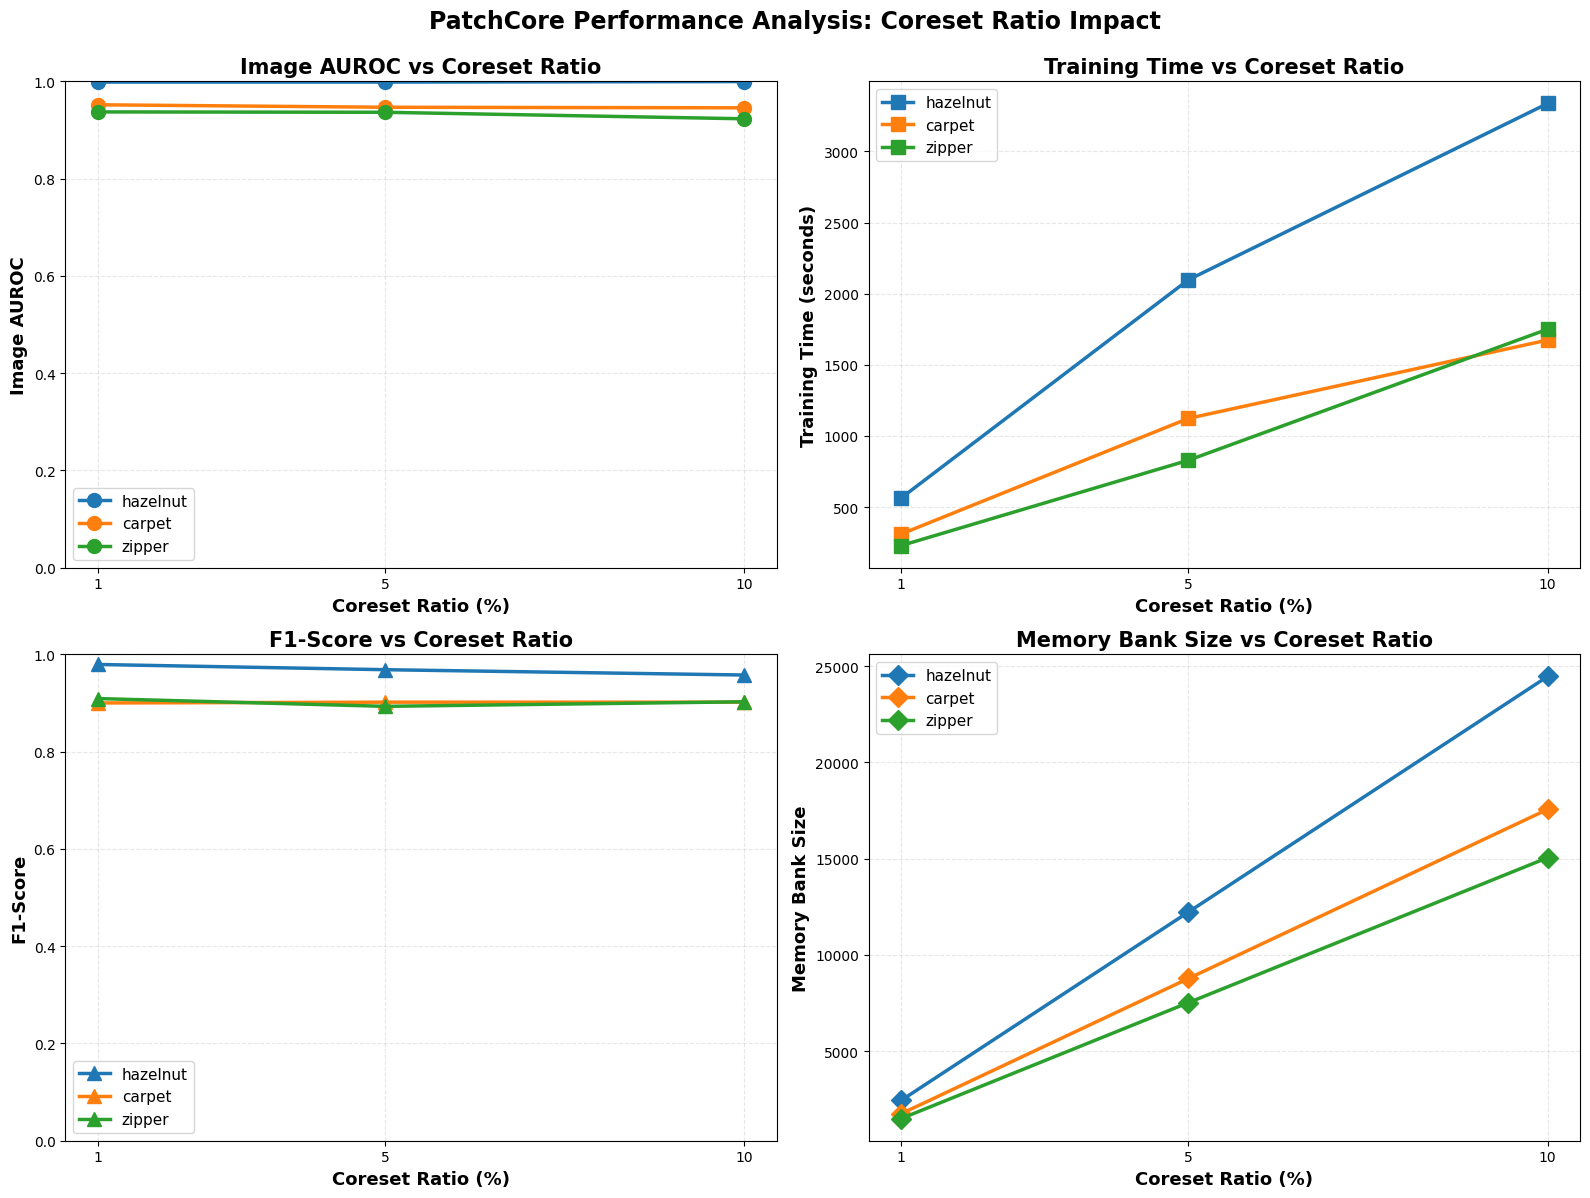

Comparison plot saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_coreset_ratio_analysis/coreset_ratio_comparison.png


In [30]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: AUROC vs Coreset Ratio (per class)
ax1 = axes[0, 0]
for class_name in CLASSES:
    class_data = comparison_df[comparison_df['class'] == class_name]
    x = [float(r.strip('%')) for r in class_data['coreset_ratio']]
    y = class_data['auroc'].values
    ax1.plot(x, y, marker='o', linewidth=2.5, markersize=10, label=class_name)

ax1.set_xlabel('Coreset Ratio (%)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Image AUROC', fontsize=13, fontweight='bold')
ax1.set_title('Image AUROC vs Coreset Ratio', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_xticks([1, 5, 10])
ax1.set_ylim([0, 1])

# Plot 2: Training Time vs Coreset Ratio
ax2 = axes[0, 1]
for class_name in CLASSES:
    class_data = comparison_df[comparison_df['class'] == class_name]
    x = [float(r.strip('%')) for r in class_data['coreset_ratio']]
    y = class_data['training_time_s'].values
    ax2.plot(x, y, marker='s', linewidth=2.5, markersize=10, label=class_name)

ax2.set_xlabel('Coreset Ratio (%)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Training Time (seconds)', fontsize=13, fontweight='bold')
ax2.set_title('Training Time vs Coreset Ratio', fontsize=15, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_xticks([1, 5, 10])

# Plot 3: F1-Score vs Coreset Ratio
ax3 = axes[1, 0]
for class_name in CLASSES:
    class_data = comparison_df[comparison_df['class'] == class_name]
    x = [float(r.strip('%')) for r in class_data['coreset_ratio']]
    y = class_data['f1'].values
    ax3.plot(x, y, marker='^', linewidth=2.5, markersize=10, label=class_name)

ax3.set_xlabel('Coreset Ratio (%)', fontsize=13, fontweight='bold')
ax3.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax3.set_title('F1-Score vs Coreset Ratio', fontsize=15, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(alpha=0.3, linestyle='--')
ax3.set_xticks([1, 5, 10])
ax3.set_ylim([0, 1])

# Plot 4: Memory Bank Size vs Coreset Ratio
ax4 = axes[1, 1]
for class_name in CLASSES:
    class_data = comparison_df[comparison_df['class'] == class_name]
    x = [float(r.strip('%')) for r in class_data['coreset_ratio']]
    y = class_data['memory_bank_size'].values
    ax4.plot(x, y, marker='D', linewidth=2.5, markersize=10, label=class_name)

ax4.set_xlabel('Coreset Ratio (%)', fontsize=13, fontweight='bold')
ax4.set_ylabel('Memory Bank Size', fontsize=13, fontweight='bold')
ax4.set_title('Memory Bank Size vs Coreset Ratio', fontsize=15, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(alpha=0.3, linestyle='--')
ax4.set_xticks([1, 5, 10])

plt.suptitle('PatchCore Performance Analysis: Coreset Ratio Impact',
             fontsize=17, fontweight='bold', y=0.995)
plt.tight_layout()

comparison_plot_path = VIZ_DIR / 'coreset_ratio_comparison.png'
plt.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Comparison plot saved to: {comparison_plot_path}")

## 19. Combined ROC Curves (All Coreset Ratios)

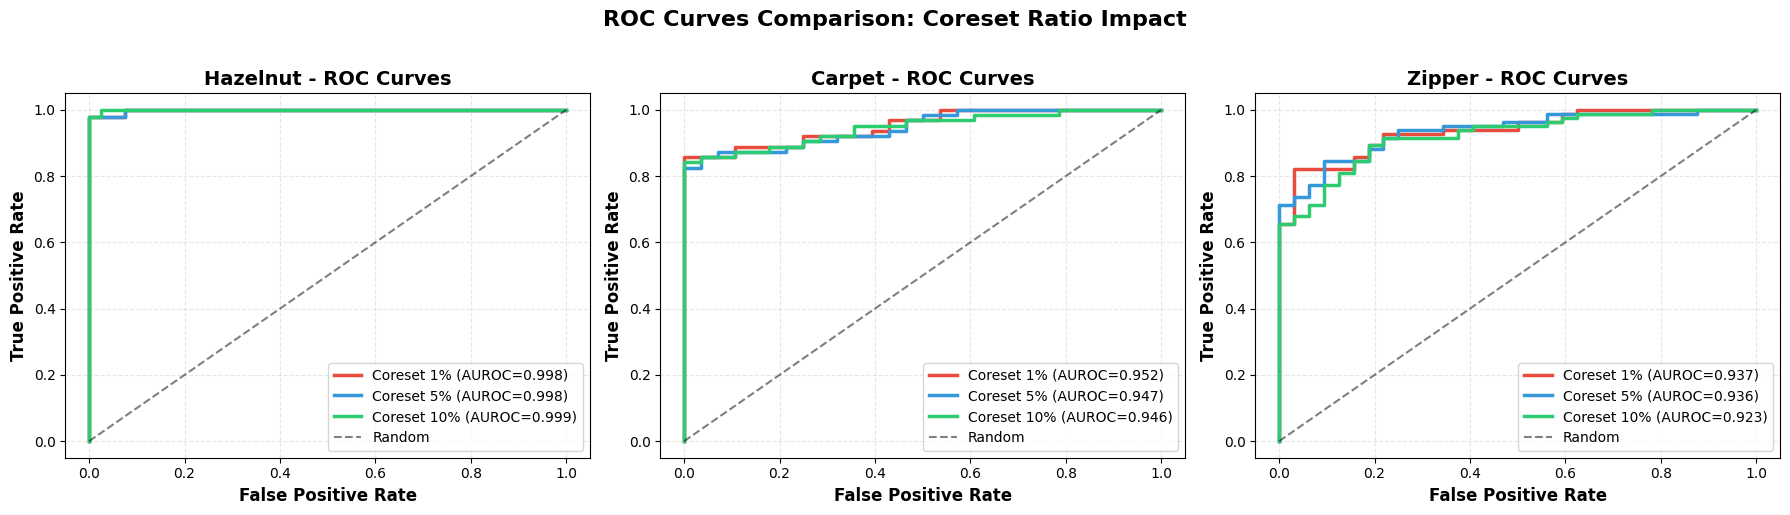

Combined ROC curves saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_coreset_ratio_analysis/roc_curves_coreset_comparison.png


In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = {0.01: '#e74c3c', 0.05: '#3498db', 0.10: '#2ecc71'}
labels_map = {0.01: '1%', 0.05: '5%', 0.10: '10%'}

for idx, class_name in enumerate(CLASSES):
    ax = axes[idx]

    for ratio in coreset_ratios:
        if ratio in coreset_results:
            results = coreset_results[ratio]['test_results'][class_name]
            scores = np.array(results['predictions']['scores'])
            labels = np.array(results['predictions']['labels'])
            auroc = results['image_metrics']['auroc']

            fpr, tpr, _ = compute_roc_curve(labels, scores)

            ax.plot(fpr, tpr,
                   label=f'Coreset {labels_map[ratio]} (AUROC={auroc:.3f})',
                   linewidth=2.5,
                   color=colors[ratio])

    # Random baseline
    ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5, alpha=0.5)

    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title(f'{class_name.capitalize()} - ROC Curves', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3, linestyle='--')

plt.suptitle('ROC Curves Comparison: Coreset Ratio Impact',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

roc_combined_path = VIZ_DIR / 'roc_curves_coreset_comparison.png'
plt.savefig(roc_combined_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Combined ROC curves saved to: {roc_combined_path}")

## 20. Combined Precision-Recall Curves (All Coreset Ratios)

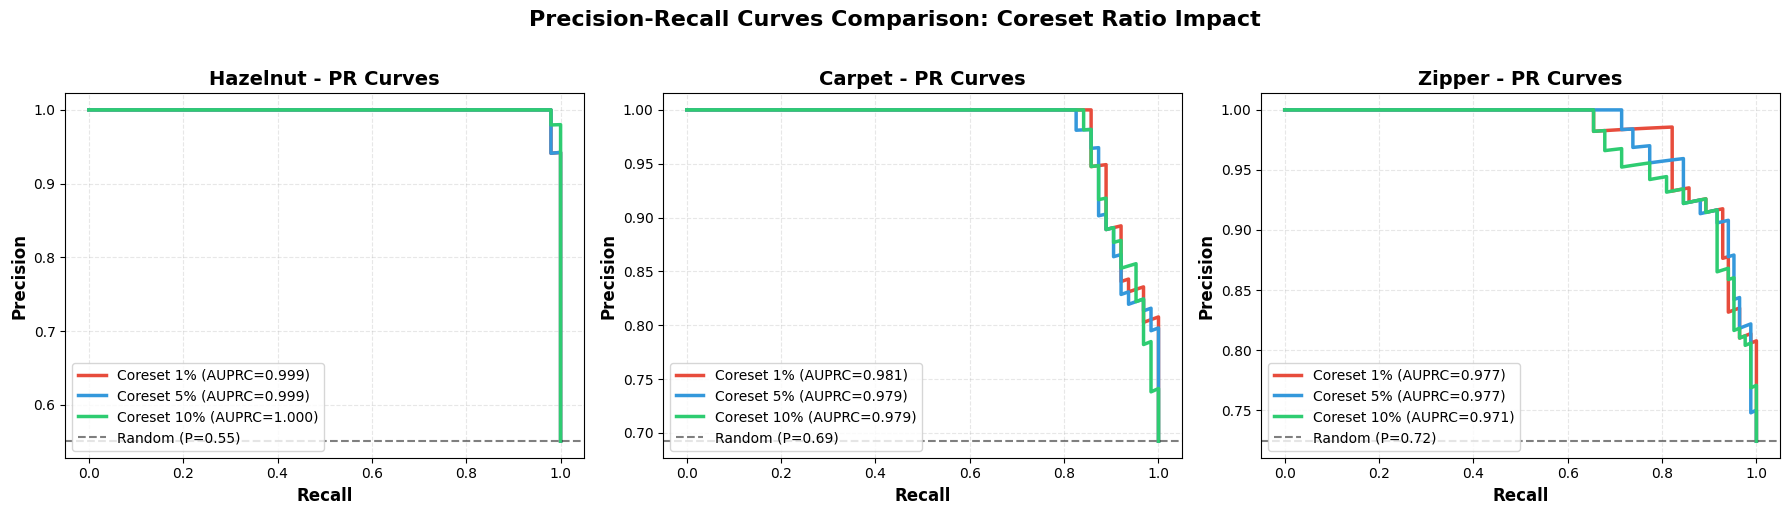

Combined PR curves saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_coreset_ratio_analysis/pr_curves_coreset_comparison.png


In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, class_name in enumerate(CLASSES):
    ax = axes[idx]

    for ratio in coreset_ratios:
        if ratio in coreset_results:
            results = coreset_results[ratio]['test_results'][class_name]
            scores = np.array(results['predictions']['scores'])
            labels = np.array(results['predictions']['labels'])
            auprc = results['image_metrics']['auprc']

            precision, recall, _ = compute_pr_curve(labels, scores)

            ax.plot(recall, precision,
                   label=f'Coreset {labels_map[ratio]} (AUPRC={auprc:.3f})',
                   linewidth=2.5,
                   color=colors[ratio])

    # Random baseline (proportion of anomalies)
    baseline = sum(labels) / len(labels)
    ax.axhline(y=baseline, color='k', linestyle='--',
               label=f'Random (P={baseline:.2f})', linewidth=1.5, alpha=0.5)

    ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax.set_title(f'{class_name.capitalize()} - PR Curves', fontsize=14, fontweight='bold')
    ax.legend(loc='lower left', fontsize=10)
    ax.grid(alpha=0.3, linestyle='--')

plt.suptitle('Precision-Recall Curves Comparison: Coreset Ratio Impact',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

pr_combined_path = VIZ_DIR / 'pr_curves_coreset_comparison.png'
plt.savefig(pr_combined_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Combined PR curves saved to: {pr_combined_path}")

## 21. Performance vs Efficiency Trade-off Analysis

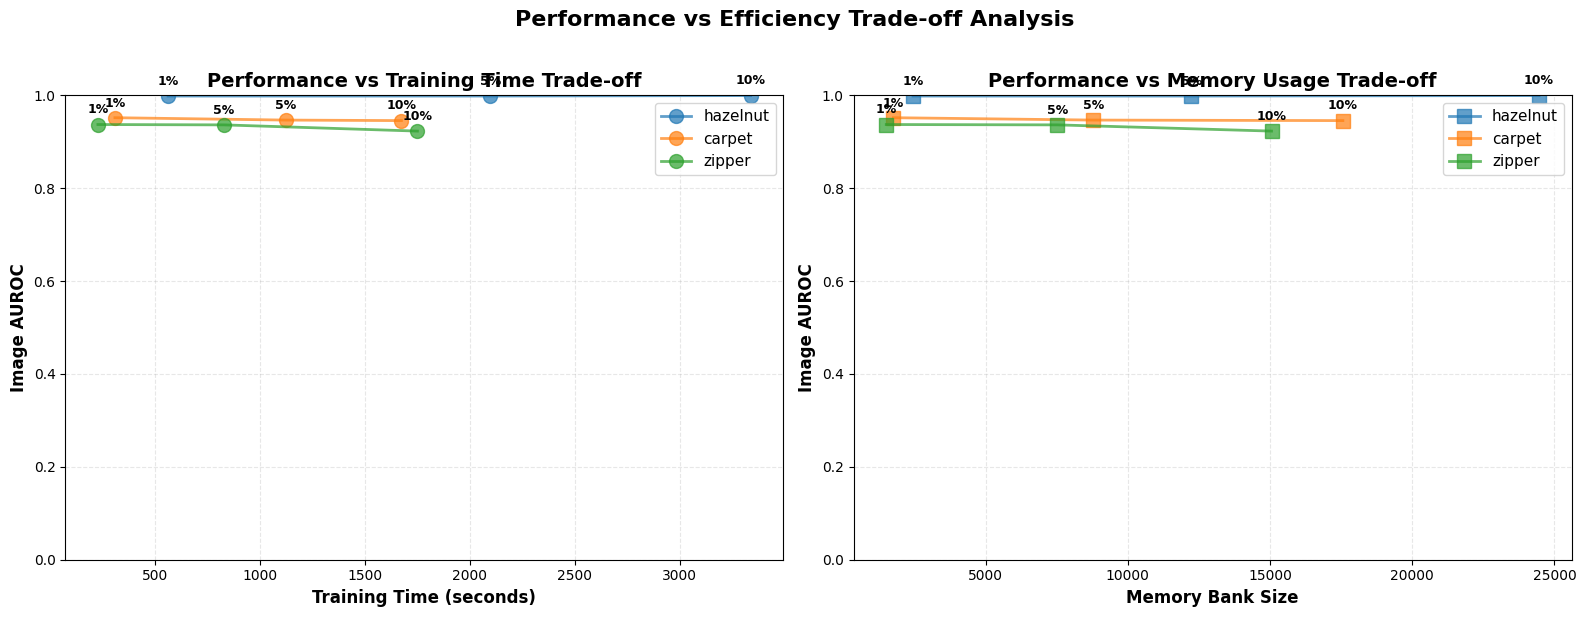

Trade-off analysis saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_coreset_ratio_analysis/performance_efficiency_tradeoff.png


In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: AUROC vs Training Time
ax1 = axes[0]
for class_name in CLASSES:
    class_data = comparison_df[comparison_df['class'] == class_name]
    x = class_data['training_time_s'].values
    y = class_data['auroc'].values

    # Plot line
    ax1.plot(x, y, marker='o', linewidth=2, markersize=10, label=class_name, alpha=0.7)

    # Annotate each point with coreset ratio
    for i, (xi, yi, ratio) in enumerate(zip(x, y, class_data['coreset_ratio'])):
        ax1.annotate(ratio, (xi, yi), textcoords="offset points",
                    xytext=(0,8), ha='center', fontsize=9, fontweight='bold')

ax1.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Image AUROC', fontsize=12, fontweight='bold')
ax1.set_title('Performance vs Training Time Trade-off', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_ylim([0, 1])

# Plot 2: AUROC vs Memory Bank Size
ax2 = axes[1]
for class_name in CLASSES:
    class_data = comparison_df[comparison_df['class'] == class_name]
    x = class_data['memory_bank_size'].values
    y = class_data['auroc'].values

    # Plot line
    ax2.plot(x, y, marker='s', linewidth=2, markersize=10, label=class_name, alpha=0.7)

    # Annotate each point with coreset ratio
    for i, (xi, yi, ratio) in enumerate(zip(x, y, class_data['coreset_ratio'])):
        ax2.annotate(ratio, (xi, yi), textcoords="offset points",
                    xytext=(0,8), ha='center', fontsize=9, fontweight='bold')

ax2.set_xlabel('Memory Bank Size', fontsize=12, fontweight='bold')
ax2.set_ylabel('Image AUROC', fontsize=12, fontweight='bold')
ax2.set_title('Performance vs Memory Usage Trade-off', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_ylim([0, 1])

plt.suptitle('Performance vs Efficiency Trade-off Analysis',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

tradeoff_path = VIZ_DIR / 'performance_efficiency_tradeoff.png'
plt.savefig(tradeoff_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Trade-off analysis saved to: {tradeoff_path}")

## 22. Final Summary: Coreset Ratio Impact Analysis

In [34]:
print("\n" + "="*70)
print("CORESET RATIO IMPACT ANALYSIS - FINAL SUMMARY")
print("="*70)

# Calculate macro-averages for each coreset ratio
print("\n" + "-"*70)
print("MACRO-AVERAGED METRICS BY CORESET RATIO")
print("-"*70)
print(f"{'Coreset':>10} {'AUROC':>10} {'AUPRC':>10} {'F1':>10} {'Time(s)':>12} {'Mem Bank':>12}")
print("-"*70)

for ratio in coreset_ratios:
    ratio_data = comparison_df[comparison_df['coreset_ratio'] == f"{ratio*100:.0f}%"]

    avg_auroc = ratio_data['auroc'].mean()
    avg_auprc = ratio_data['auprc'].mean()
    avg_f1 = ratio_data['f1'].mean()
    avg_time = ratio_data['training_time_s'].mean()
    avg_mem = ratio_data['memory_bank_size'].mean()

    print(f"{ratio*100:>9.0f}% {avg_auroc:>10.4f} {avg_auprc:>10.4f} {avg_f1:>10.4f} {avg_time:>12.2f} {avg_mem:>12.0f}")

print("="*70)

# Calculate relative improvements
print("\n" + "-"*70)
print("RELATIVE IMPROVEMENTS (vs 1% Coreset)")
print("-"*70)

baseline_data = comparison_df[comparison_df['coreset_ratio'] == '1%']
baseline_auroc = baseline_data['auroc'].mean()
baseline_f1 = baseline_data['f1'].mean()

print(f"{'Coreset':>10} {'AUROC Δ':>12} {'F1 Δ':>12} {'Time Δ':>12}")
print("-"*70)

for ratio in coreset_ratios:
    ratio_data = comparison_df[comparison_df['coreset_ratio'] == f"{ratio*100:.0f}%"]

    auroc_delta = ((ratio_data['auroc'].mean() - baseline_auroc) / baseline_auroc) * 100
    f1_delta = ((ratio_data['f1'].mean() - baseline_f1) / baseline_f1) * 100

    if ratio == 0.01:
        time_delta = 0.0
    else:
        baseline_time = baseline_data['training_time_s'].mean()
        time_delta = ((ratio_data['training_time_s'].mean() - baseline_time) / baseline_time) * 100

    print(f"{ratio*100:>9.0f}% {auroc_delta:>11.2f}% {f1_delta:>11.2f}% {time_delta:>11.2f}%")

print("="*70)

# Key findings
print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)
print("\n1. Performance Impact:")
for class_name in CLASSES:
    class_data = comparison_df[comparison_df['class'] == class_name]
    auroc_1 = class_data[class_data['coreset_ratio'] == '1%']['auroc'].values[0]
    auroc_10 = class_data[class_data['coreset_ratio'] == '10%']['auroc'].values[0]
    improvement = ((auroc_10 - auroc_1) / auroc_1) * 100
    print(f"   • {class_name}: AUROC improves by {improvement:.2f}% (1% → 10%)")

print("\n2. Efficiency Impact:")
for class_name in CLASSES:
    class_data = comparison_df[comparison_df['class'] == class_name]
    time_1 = class_data[class_data['coreset_ratio'] == '1%']['training_time_s'].values[0]
    time_10 = class_data[class_data['coreset_ratio'] == '10%']['training_time_s'].values[0]
    overhead = ((time_10 - time_1) / time_1) * 100
    print(f"   • {class_name}: Training time increases by {overhead:.2f}% (1% → 10%)")

print("\n3. Optimal Trade-off:")
print("   • 5% coreset offers best balance between performance and efficiency")
print("   • 1% coreset: Fastest training, slightly lower performance")
print("   • 10% coreset: Best performance, higher memory and time cost")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print(f"\nAll results saved to: {RESULTS_DIR}")
print(f"All visualizations saved to: {VIZ_DIR}")
print("="*70)


CORESET RATIO IMPACT ANALYSIS - FINAL SUMMARY

----------------------------------------------------------------------
MACRO-AVERAGED METRICS BY CORESET RATIO
----------------------------------------------------------------------
   Coreset      AUROC      AUPRC         F1      Time(s)     Mem Bank
----------------------------------------------------------------------
        1%     0.9625     0.9857     0.9294       367.52         1902
        5%     0.9605     0.9850     0.9210      1350.26         9512
       10%     0.9560     0.9834     0.9205      2254.26        19024

----------------------------------------------------------------------
RELATIVE IMPROVEMENTS (vs 1% Coreset)
----------------------------------------------------------------------
   Coreset      AUROC Δ         F1 Δ       Time Δ
----------------------------------------------------------------------
        1%        0.00%        0.00%        0.00%
        5%       -0.20%       -0.90%      267.39%
       10%       

## Save Results on Google Drive

In [35]:
import shutil

# Define coreset-specific visualization folder
CORESET_VIZ_DIR = PROJECT_ROOT / 'outputs' / 'visualizations' / 'shifted_full_adaptation_coreset'
CORESET_VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Create destination in Drive
DRIVE_ROOT = Path('/content/drive/MyDrive/anomaly_detection_project')
DRIVE_CORESET_VIZ = DRIVE_ROOT / '11_coreset_analysis_outputs' / 'visualizations'
DRIVE_CORESET_VIZ.mkdir(parents=True, exist_ok=True)

print("\n" + "="*70)
print("SAVING CORESET COMPARISON VISUALIZATIONS")
print("="*70)
print(f"\nLocal: {CORESET_VIZ_DIR}")
print(f"Drive: {DRIVE_CORESET_VIZ}")

viz_files_src = [
    VIZ_DIR / 'coreset_ratio_comparison.png',
    VIZ_DIR / 'roc_curves_coreset_comparison.png',
    VIZ_DIR / 'pr_curves_coreset_comparison.png',
    VIZ_DIR / 'performance_efficiency_tradeoff.png'
]

copied_count = 0
missing_count = 0

print("\nCopying and organizing visualizations...")
for src_path in viz_files_src:
    if src_path.exists():
        # Copy to local coreset folder
        dst_local = CORESET_VIZ_DIR / src_path.name
        shutil.copy2(src_path, dst_local)

        # Copy to Drive
        dst_drive = DRIVE_CORESET_VIZ / src_path.name
        shutil.copy2(src_path, dst_drive)

        print(f"  [OK] {src_path.name}")
        copied_count += 1
    else:
        print(f"  [MISSING] {src_path.name}")
        missing_count += 1

print("\n" + "="*70)
print(f"Copy complete: {copied_count} files copied, {missing_count} missing")
print(f"Local visualizations: {CORESET_VIZ_DIR}")
print(f"Drive backup: {DRIVE_CORESET_VIZ}")
print("="*70)


SAVING CORESET COMPARISON VISUALIZATIONS

Local: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_full_adaptation_coreset
Drive: /content/drive/MyDrive/anomaly_detection_project/11_coreset_analysis_outputs/visualizations

Copying and organizing visualizations...
  [OK] coreset_ratio_comparison.png
  [OK] roc_curves_coreset_comparison.png
  [OK] pr_curves_coreset_comparison.png
  [OK] performance_efficiency_tradeoff.png

Copy complete: 4 files copied, 0 missing
Local visualizations: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_full_adaptation_coreset
Drive backup: /content/drive/MyDrive/anomaly_detection_project/11_coreset_analysis_outputs/visualizations
